# Projekt 2  Analýza cen bydlení v Brně 



# Analýza dat

1) Příprava

2) Výpočet průměrného tempa růstu

3) Obecné charakteristiky polohy

4) Vizualizace časové řady a procentuálních změn

5) Sezónnost

6) Korelace




## 1) Příprava dat

In [258]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

df_ceny = pd.read_csv('vyvoj cen bytu.csv', index_col=[0], parse_dates=[0])

#novy dataframe, kde budou ceny pro jednotlive roky -> kvuli porovnani s ostatnimi promennymi, ktere jsou zaznamenavany rocne

df_ceny_Y = df_ceny[df_ceny.index.month == 1][['prodej (cena m2)','pronajem (cena m2)']]


#vypocet tempa rustu pro jednotliva obdobi (YG - year growth, MG - month growth)
df_ceny_Y[['prodej YG', 'pronajem YG']] = df_ceny_Y.sort_values(['datum'])[['prodej (cena m2)','pronajem (cena m2)']].pct_change()
df_ceny[['prodej MG', 'pronajem MG']] = df_ceny.sort_values(['datum'])[['prodej (cena m2)','pronajem (cena m2)']].pct_change()


In [ ]:
#otevreni vsech pracovnich df, vypocet mezirocnich zmen v %

df_vystavba = pd.read_csv('vystavba bytu Brno.csv', index_col=[0], parse_dates=[0])
df_vystavba['byty_YG'] = df_vystavba.sort_values(['datum'])['pocet_dok_bytu'].pct_change()
df_obyv = pd.read_csv('pohyb obyvatelstva Brno.csv', index_col=[0], parse_dates=[0])
df_obyv['migrace_YG'] = df_obyv.sort_values(['datum'])['Migrační saldo'].pct_change()
df_obyv['prir_phyb_YG'] = df_obyv.sort_values(['datum'])['Přirozený přírůstek'].pct_change()
df_makro = pd.read_csv('hdp a cddd jmk.csv', index_col=[0], parse_dates=[0])
df_makro['HDP_YG'] = df_makro.sort_values(['datum'])['HDP_obyv'].pct_change()
df_makro['CDDD_YG'] = df_makro.sort_values(['datum'])['ČDDD_obyv'].pct_change()
df_mzda = pd.read_csv('prumerna mzda Brno.csv', index_col=[0], parse_dates=[0])
df_mzda['mzda_YG'] = df_mzda.sort_values(['datum'])['prumerna mzda'].pct_change()
df_hypo = pd.read_csv('sazby hypotek.csv', index_col=[0], parse_dates=[0])
df_hypo['pribor_MG'] = df_hypo.sort_values(['Datum'])['Pribor 3M'].pct_change()
df_hypo['hypo_MG'] = df_hypo.sort_values(['Datum'])['Prum_sazba_hypotek'].pct_change()

In [ ]:
#spojeni do jednoho df vsechno, co je sledovano na rocni bazi

df_ceny_Y.index = pd.Series(index=df_ceny_Y.index).tshift(periods=-1, freq='D').index
list_series = [df_ceny_Y[['prodej YG', 'pronajem YG']],
               df_obyv['prir_phyb_YG'],
               df_obyv['migrace_YG'],
               df_vystavba['byty_YG'],
               df_makro['HDP_YG'],
               df_makro['CDDD_YG'],
               df_mzda['mzda_YG']
              ]

df_YG_all = pd.concat(list_series, axis=1)
df_YG_all.dropna(thresh=4, inplace=True)
df_YG_all

In [ ]:
#jeden df s daty, ktere jsou nasbirana mesicne

df_ceny.index = pd.Series(index=df_ceny.index).tshift(periods=-1, freq='D').index

list_series2 = [df_ceny[['prodej MG', 'pronajem MG']], df_hypo[['pribor_MG', 'hypo_MG']]]

df_MG_all = pd.concat(list_series2, axis=1)
df_MG_all.dropna(thresh=3, inplace=True)
df_MG_all

## 2) Průměrné tempo růstu

In [283]:
#prumerne tempo rustu - geometricky prumer
Gmean_prodej = round(((((df_ceny.iloc[-1,0])/(df_ceny.iloc[0,0]))**(1/70))*100)-100,4)
Gmean_pronajem = round(((((df_ceny.iloc[-1,2])/(df_ceny.iloc[0,2]))**(1/70))*100)-100,4)
print('Prumerne tempo rustu cen bytu k prodeji:', Gmean_prodej)
print('Prumerne tempo rustu cen bytu k pronajmu:', Gmean_pronajem)

Prumerne tempo rustu cen bytu k prodeji: 0.8599
Prumerne tempo rustu cen bytu k pronajmu: 0.5647


Průměrné tempo růstu cen bytů na m2 je 85.99%, průměrné tempo růstu cen pronájmů na m2 je 56.47%. Ceny bytů k prodeji tedy rostou rychleji než ceny bytů k pronájmu. 

## 3) Obecne charakteristiky polohy a variability

In [170]:
df_ceny.describe()

,prodej (cena m2),prodej (cena bytu),pronajem (cena m2),pronajem (cena bytu),prodej MG,pronajem MG
count,71.000000,7.100000e+01,71.000000,71.00000,70.000000,70.000000
mean,58009.591549,4.278312e+06,232.169014,14040.56338,0.008685,0.005818
std,9438.423259,7.373172e+05,30.087960,1335.43816,0.013222,0.018640
min,42009.000000,3.099170e+06,178.000000,11308.00000,-0.044078,-0.043956
25%,51914.000000,3.858410e+06,207.500000,13068.50000,0.002794,-0.007052
50%,55927.000000,4.006544e+06,230.000000,14371.00000,0.008755,0.006462
75%,63521.500000,4.551932e+06,262.000000,15083.50000,0.016656,0.019024
max,77000.000000,5.727206e+06,280.000000,16004.00000,0.047892,0.041841


Minimální cena bytu je 42009Kč na m2, což byla cena za m2 bytu na začátku roku 2015. Nejvyšší částka je 77000Kč na m2 ze srpna roku 2020. Medián cen bytů za celé období je 55927Kč na m2, průměrná cena je 58009Kč na m2. 
U cen pronájmů je nejnižší částka 178Kč za m2, což je opět cena z ledna 2015. Nejvyšší cena pronájmu byla v září 2019 ve výši 280Kč za m2. Medián cen pronájmu za celé sledované období je 230Kč na m2 a průměr 232Kč na m2.

## 4) Vizualizace časové řady původních dat a procentuálních změn 

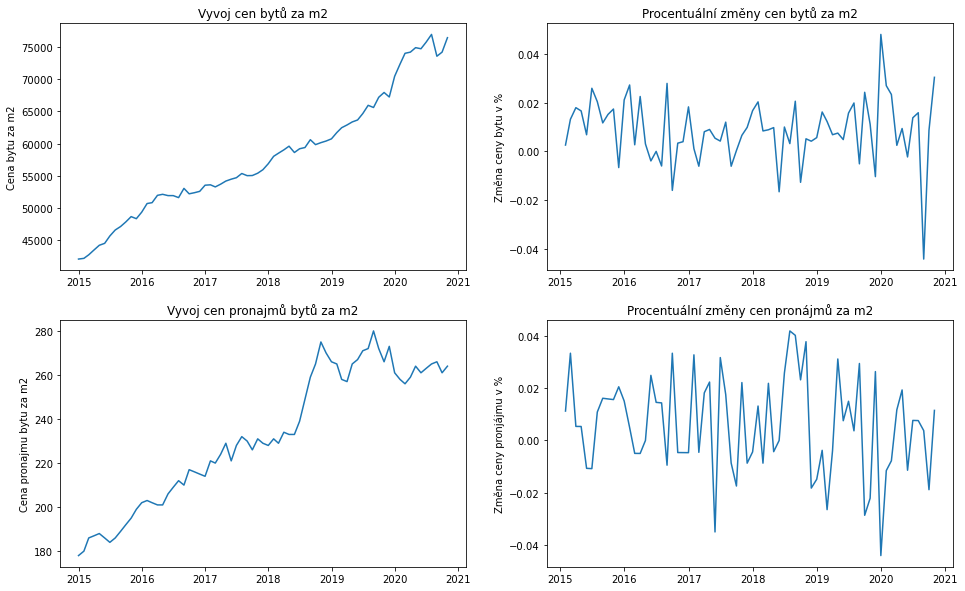

In [196]:
fig = plt.figure(figsize=(16, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(df_ceny['prodej (cena m2)'])
ax1.set_ylabel('Cena bytu za m2')
ax1.set_title('Vyvoj cen bytů za m2')

ax2 = fig.add_subplot(2,2,2)
ax2.plot(df_ceny['prodej MG'])
ax2.set_ylabel('Změna ceny bytu v %')
ax2.set_title('Procentuální změny cen bytů za m2')

ax3 = fig.add_subplot(2,2,3)
ax3.plot(df_ceny['pronajem (cena m2)'])
ax3.set_ylabel('Cena pronajmu bytu za m2')
ax3.set_title('Vyvoj cen pronajmů bytů za m2')

ax4 = fig.add_subplot(2,2,4)
ax4.plot(df_ceny['pronajem MG'])
ax4.set_ylabel('Změna ceny pronjájmu v %')
ax4.set_title('Procentuální změny cen pronájmů za m2')

plt.show()

Ceny bytů od roku 2015 rostou. Výrazný pokles proběhl v září 2020. Ceny pronájmů mají také rostoucí trend, na začátku roku 2020 ceny mírně klesly, ale už od února opět vzrostly.


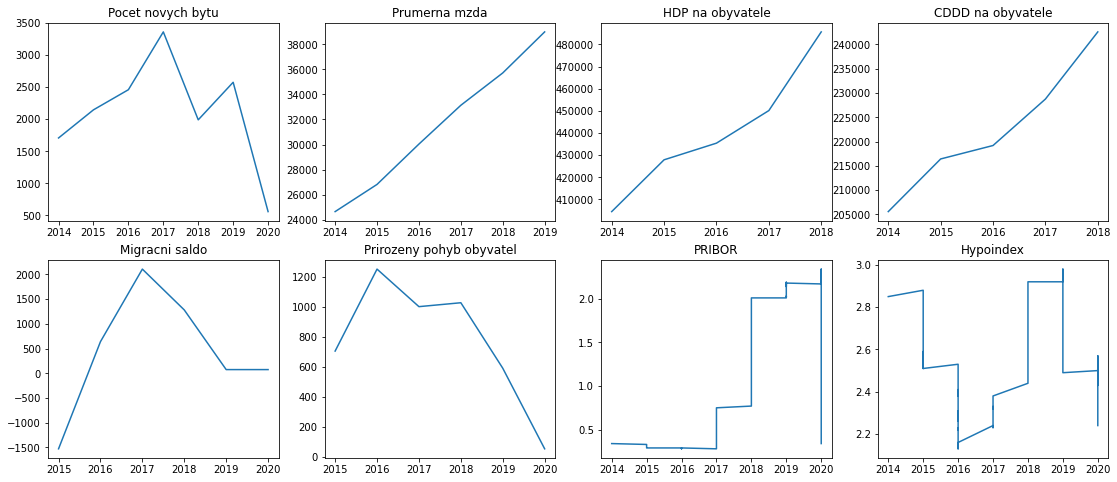

In [300]:
fig = plt.figure(figsize=(19, 8))

ax1 = fig.add_subplot(2,4,1)
ax1.plot(df_vystavba.index.year, df_vystavba['pocet_dok_bytu'])
ax1.set_title('Pocet novych bytu')

ax2 = fig.add_subplot(2,4,2)
ax2.plot(df_mzda.index.year, df_mzda['prumerna mzda'])
ax2.set_title('Prumerna mzda')

ax3 = fig.add_subplot(2,4,3)
ax3.plot(df_makro.index.year, df_makro['HDP_obyv'])
ax3.set_title('HDP na obyvatele')

ax4 = fig.add_subplot(2,4,4)
ax4.plot(df_makro.index.year, df_makro['ČDDD_obyv'])
ax4.set_title('CDDD na obyvatele')

ax5 = fig.add_subplot(2,4,5)
ax5.plot(df_obyv.index.year, df_obyv['Migrační saldo'])
ax5.set_title('Migracni saldo')

ax6 = fig.add_subplot(2,4,6)
ax6.plot(df_obyv.index.year, df_obyv['Přirozený přírůstek'])
ax6.set_title('Prirozeny pohyb obyvatel')

ax7 = fig.add_subplot(2,4,7)
ax7.plot(df_hypo.index.year, df_hypo['Pribor 3M'])
ax7.set_title('PRIBOR')

ax8 = fig.add_subplot(2,4,8)
ax8.plot(df_hypo.index.year, df_hypo['Prum_sazba_hypotek'])
ax8.set_title('Hypoindex')


plt.show()


Grafy zobrazují čistá data v jenotlivých letech. Pro analýzu korelace mezi cenami bytů a jednotlivými proměnnými se bude dále pracovat pouze s procentuálními přírůstky. 

## 5) Sezónnost

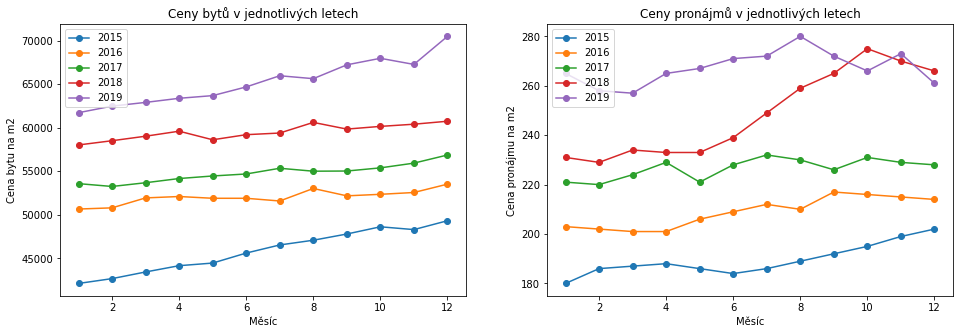

In [239]:
years = [2015, 2016, 2017, 2018, 2019]
months = range(1,13)

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1,2,1)
for year in years:
        ax1.plot(months, df_ceny[df_ceny.index.year == year]['prodej (cena m2)'], marker='o', label=year)
ax1.legend(loc="upper left")
ax1.set_title('Ceny bytů v jednotlivých letech')
ax1.set_xlabel('Měsíc')
ax1.set_ylabel('Cena bytu na m2')


ax2 = fig.add_subplot(1,2,2)
for year in years:
        ax2.plot(months, df_ceny[df_ceny.index.year == year]['pronajem (cena m2)'], marker='o', label=year)
ax2.legend(loc="upper left")
ax2.set_title('Ceny pronájmů v jednotlivých letech')
ax2.set_xlabel('Měsíc')
ax2.set_ylabel('Cena pronájmu na m2')

plt.show()

Z grafů nelzou vyčíst sezónní vlivy na ceny bytů a pronájmů. 

## 5) Korelace mezi cenou bytů, průměrnou sazbou hypoték a sazby PRIBOR

c:\users\ecvan\da\venvec\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\ecvan\da\venvec\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\ecvan\da\venvec\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
c:\users\ecvan\da\venvec\lib\site-packages\pandas\plotting\_matpl

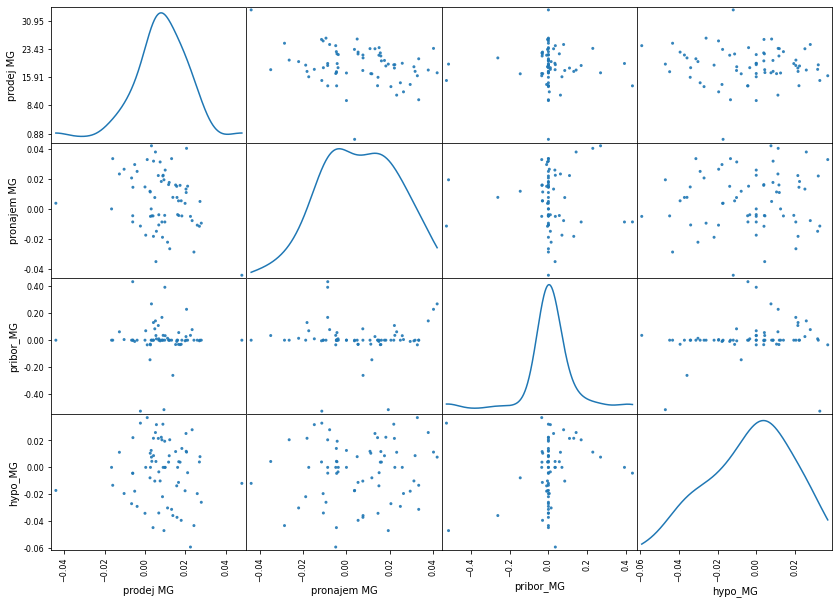

In [284]:
from pandas.plotting import scatter_matrix
from matplotlib.ticker import FormatStrFormatter

axes = scatter_matrix(df_MG_all, figsize=(14,10), alpha=0.9, diagonal='kde')
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

In [285]:
df_MG_all.corr()

,prodej MG,pronajem MG,pribor_MG,hypo_MG
prodej MG,1.000000,-0.284866,-0.011108,-0.056002
pronajem MG,-0.284866,1.000000,0.014817,0.088605
pribor_MG,-0.011108,0.014817,1.000000,0.175739
hypo_MG,-0.056002,0.088605,0.175739,1.000000


Pro výpočet korelace byly použity měsíční procentuální změny. Časové řady cen bytů a pronájmů mají výrazně rostoucí trend a korelace s původními daty by tedy mohla být zkreslená. Korelace mezi průměrnou sazbou hypoték, sazbou PRIBOR a cenami bytů a pronájmů je poměrně slabá a pohybují se kolem 0. 

## 6) Korelace mezi cenami bytů a ostatními proměnnými

### a) Cena bytů k prodeji na m2 a ostatní proměnné


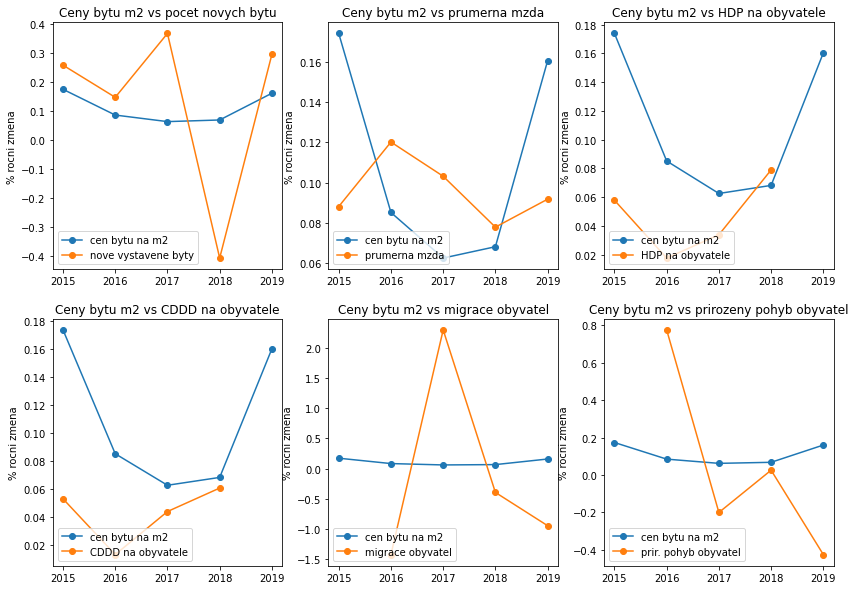

In [281]:
#scatter ploty nejdou mame malo bodu
years = df_YG_all.index.year

fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_subplot(2,3,1)
ax1.plot(years, df_YG_all['prodej YG'], marker='o', label='ceny bytu na m2') 
ax1.plot(years, df_YG_all['byty_YG'], marker='o', label='nove vystavene byty')
ax1.legend(loc="lower left")
ax1.set_title('Ceny bytu m2 vs pocet novych bytu')
ax1.set_ylabel('% rocni zmena')


ax2 = fig.add_subplot(2,3,2) 
ax2.plot(years, df_YG_all['prodej YG'], marker='o', label='ceny bytu na m2')
ax2.plot(years, df_YG_all['mzda_YG'], marker='o', label='prumerna mzda')
ax2.legend(loc="lower left")
ax2.set_title('Ceny bytu m2 vs prumerna mzda')
ax2.set_ylabel('% rocni zmena')

ax3 = fig.add_subplot(2,3,3)
ax3.plot(years, df_YG_all['prodej YG'], marker='o', label='ceny bytu na m2')
ax3.plot(years, df_YG_all['HDP_YG'], marker='o', label='HDP na obyvatele')
ax3.legend(loc="lower left")
ax3.set_title('Ceny bytu m2 vs HDP na obyvatele')
ax3.set_ylabel('% rocni zmena')

ax4 = fig.add_subplot(2,3,4)
ax4.plot(years, df_YG_all['prodej YG'], marker='o', label='ceny bytu na m2')
ax4.plot(years, df_YG_all['CDDD_YG'], marker='o', label='CDDD na obyvatele')
ax4.legend(loc="lower left")
ax4.set_title('Ceny bytu m2 vs CDDD na obyvatele')
ax4.set_ylabel('% rocni zmena')

ax5 = fig.add_subplot(2,3,5)
ax5.plot(years, df_YG_all['prodej YG'], marker='o', label='ceny bytu na m2')
ax5.plot(years, df_YG_all['migrace_YG'], marker='o', label='migrace obyvatel')
ax5.legend(loc="lower left")
ax5.set_title('Ceny bytu m2 vs migrace obyvatel')
ax5.set_ylabel('% rocni zmena')

ax6 = fig.add_subplot(2,3,6)
ax6.plot(years, df_YG_all['prodej YG'], marker='o', label='ceny bytu na m2')
ax6.plot(years, df_YG_all['prir_phyb_YG'], marker='o', label='prir. pohyb obyvatel')
ax6.legend(loc="lower left")
ax6.set_title('Ceny bytu m2 vs prirozeny pohyb obyvatel')
ax6.set_ylabel('% rocni zmena')

plt.show()


### b) Cena bytů k pronájmu na m2 a ostatní proměnné

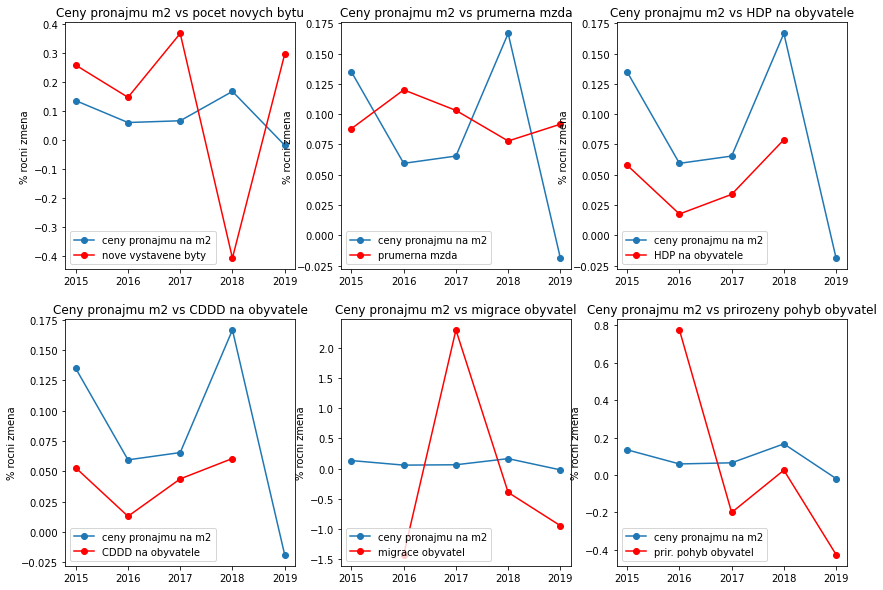

In [287]:
years = df_YG_all.index.year

fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_subplot(2,3,1)
ax1.plot(years, df_YG_all['pronajem YG'], marker='o', label='ceny pronajmu na m2') 
ax1.plot(years, df_YG_all['byty_YG'], marker='o', color='#FF0000', label='nove vystavene byty')
ax1.legend(loc="lower left")
ax1.set_title('Ceny pronajmu m2 vs pocet novych bytu')
ax1.set_ylabel('% rocni zmena')


ax2 = fig.add_subplot(2,3,2) 
ax2.plot(years, df_YG_all['pronajem YG'], marker='o', label='ceny pronajmu na m2')
ax2.plot(years, df_YG_all['mzda_YG'], marker='o', color='#FF0000', label='prumerna mzda')
ax2.legend(loc="lower left")
ax2.set_title('Ceny pronajmu m2 vs prumerna mzda')
ax2.set_ylabel('% rocni zmena')

ax3 = fig.add_subplot(2,3,3)
ax3.plot(years, df_YG_all['pronajem YG'], marker='o', label='ceny pronajmu na m2')
ax3.plot(years, df_YG_all['HDP_YG'], marker='o', color='#FF0000', label='HDP na obyvatele')
ax3.legend(loc="lower left")
ax3.set_title('Ceny pronajmu m2 vs HDP na obyvatele')
ax3.set_ylabel('% rocni zmena')

ax4 = fig.add_subplot(2,3,4)
ax4.plot(years, df_YG_all['pronajem YG'], marker='o', label='ceny pronajmu na m2')
ax4.plot(years, df_YG_all['CDDD_YG'], marker='o', color='#FF0000', label='CDDD na obyvatele')
ax4.legend(loc="lower left")
ax4.set_title('Ceny pronajmu m2 vs CDDD na obyvatele')
ax4.set_ylabel('% rocni zmena')

ax5 = fig.add_subplot(2,3,5)
ax5.plot(years, df_YG_all['pronajem YG'], marker='o', label='ceny pronajmu na m2')
ax5.plot(years, df_YG_all['migrace_YG'], marker='o', color='#FF0000', label='migrace obyvatel')
ax5.legend(loc="lower left")
ax5.set_title('Ceny pronajmu m2 vs migrace obyvatel')
ax5.set_ylabel('% rocni zmena')

ax6 = fig.add_subplot(2,3,6)
ax6.plot(years, df_YG_all['pronajem YG'], marker='o', label='ceny pronajmu na m2')
ax6.plot(years, df_YG_all['prir_phyb_YG'], marker='o', color='#FF0000', label='prir. pohyb obyvatel')
ax6.legend(loc="lower left")
ax6.set_title('Ceny pronajmu m2 vs prirozeny pohyb obyvatel')
ax6.set_ylabel('% rocni zmena')

plt.show()

In [286]:
df_YG_all.corr()

,prodej YG,pronajem YG,prir_phyb_YG,migrace_YG,byty_YG,HDP_YG,CDDD_YG,mzda_YG
prodej YG,1.000000,-0.254058,-0.416618,-0.496847,0.412593,0.171006,0.179502,-0.262710
pronajem YG,-0.254058,1.000000,0.279794,0.130520,-0.662092,0.976124,0.824072,-0.468560
prir_phyb_YG,-0.416618,0.279794,1.000000,-0.442811,-0.206422,-0.529718,-0.837281,0.651583
migrace_YG,-0.496847,0.130520,-0.442811,1.000000,0.321698,0.005371,0.425390,-0.064339
byty_YG,0.412593,-0.662092,-0.206422,0.321698,1.000000,-0.697253,-0.397698,0.503351
HDP_YG,0.171006,0.976124,-0.529718,0.005371,-0.697253,1.000000,0.913514,-0.986979
CDDD_YG,0.179502,0.824072,-0.837281,0.425390,-0.397698,0.913514,1.000000,-0.965102
mzda_YG,-0.262710,-0.468560,0.651583,-0.064339,0.503351,-0.986979,-0.965102,1.000000


I v tomto případě byly pro korelaci použity procentuální změny, aby korelace nebyla zkreslená rostoucím trendem časových řad cen bytů a pronájmů. Jelikož je zde porovnáváno malé množství hodnot, pro přehlednější vizualizaci jsou vtahy zobrazeny pomocí spojnicových grafů. 
Nejsilnější pozitivní korelace je mezi cenami pronájmů a hodnotami HDP na obyvatele a hodnotami čistého disponibilního důchodu domácností. Poměrně silná negativní korelace je také mezi cenami pronájmů a počtem vystavených bytů. 